In [1]:
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, LeakyReLU  
from tensorflow.keras.models import Sequential  

def build_generator():  
    model = Sequential([  
        Dense(7*7*256, use_bias=False, input_shape=(100,)),  # Input: 100-dimensional noise  
        BatchNormalization(),  
        LeakyReLU(alpha=0.2),  
        Reshape((7, 7, 256)),  
        Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False),  
        BatchNormalization(),  
        LeakyReLU(0.2),  
        Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False),  
        BatchNormalization(),  
        LeakyReLU(0.2),  
        Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh')  
    ])  
    return model  

generator = build_generator()  

In [2]:
from tensorflow.keras.layers import Conv2D, Flatten, Dropout  

def build_discriminator():  
    model = Sequential([  
        Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=(28,28,1)),  
        LeakyReLU(0.2),  
        Dropout(0.3),  
        Conv2D(128, (5,5), strides=(2,2), padding='same'),  
        LeakyReLU(0.2),  
        Dropout(0.3),  
        Flatten(),  
        Dense(1, activation='sigmoid')  
    ])  
    return model  

discriminator = build_discriminator()  

In [3]:
from tensorflow.keras.optimizers import Adam  

discriminator.compile(  
    loss='binary_crossentropy',  
    optimizer=Adam(learning_rate=0.0002, beta_1=0.5),  
    metrics=['accuracy']  
)  

discriminator.trainable = False  # Freeze during generator training  
gan = Sequential([generator, discriminator])  
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, beta_1=0.5))  

In [4]:
from tensorflow.keras.datasets import mnist  
import numpy as np  

(train_images, _), (_, _) = mnist.load_data()  
train_images = (train_images.astype('float32') - 127.5) / 127.5  # Normalize to [-1, 1]  
train_images = np.expand_dims(train_images, axis=-1)  # Add channel dimension  

In [5]:
epochs = 50  
batch_size = 64  

for epoch in range(epochs):  
    # Train discriminator on real + fake images  
    idx = np.random.randint(0, train_images.shape[0], batch_size)  
    real_images = train_images[idx]  
    noise = np.random.normal(0, 1, (batch_size, 100))  
    fake_images = generator.predict(noise)  

    # Label real=1, fake=0  
    d_loss_real = discriminator.train_on_batch(real_images, np.ones((batch_size, 1)))  
    d_loss_fake = discriminator.train_on_batch(fake_images, np.zeros((batch_size, 1)))  
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)  

    # Train generator to fool the discriminator  
    noise = np.random.normal(0, 1, (batch_size, 100))  
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))  

    # Print progress  
    if epoch % 5 == 0:  
        print(f"Epoch {epoch}: D Loss = {d_loss[0]:.2f}, G Loss = {g_loss:.2f}")  

2/2 [==============================] - 0s 78ms/step
Epoch 0: D Loss = 0.70, G Loss = 0.66
2/2 [==============================] - 0s 95ms/step
Epoch 5: D Loss = 0.44, G Loss = 0.30
2/2 [==============================] - 0s 90ms/step
Epoch 10: D Loss = 0.37, G Loss = 0.10
2/2 [==============================] - 0s 89ms/step
Epoch 15: D Loss = 0.37, G Loss = 0.07
2/2 [==============================] - 0s 81ms/step
Epoch 20: D Loss = 0.37, G Loss = 0.07
2/2 [==============================] - 0s 90ms/step
Epoch 25: D Loss = 0.33, G Loss = 0.08
2/2 [==============================] - 0s 83ms/step
Epoch 30: D Loss = 0.26, G Loss = 0.05
2/2 [==============================] - 0s 95ms/step
Epoch 35: D Loss = 0.16, G Loss = 0.04
2/2 [==============================] - 0s 79ms/step
Epoch 40: D Loss = 0.08, G Loss = 0.03
2/2 [==============================] - 0s 83ms/step
Epoch 45: D Loss = 0.04, G Loss = 0.02
2/2 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 179ms/step


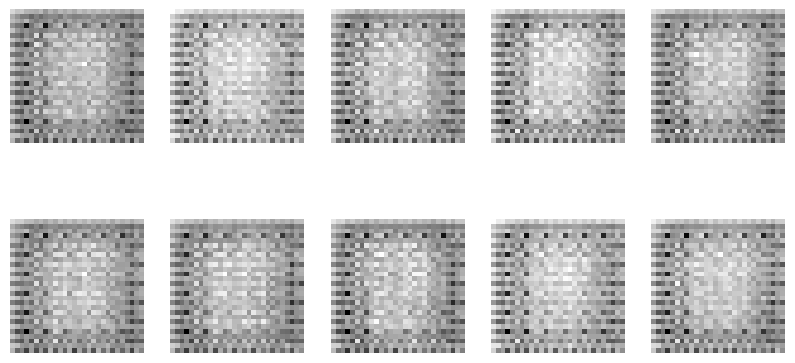

In [6]:
import matplotlib.pyplot as plt  

def plot_generated_images(generator, examples=10):  
    noise = np.random.normal(0, 1, (examples, 100))  
    generated_images = generator.predict(noise)  
    plt.figure(figsize=(10, 5))  
    for i in range(examples):  
        plt.subplot(2, 5, i+1)  
        plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')  
        plt.axis('off')  
    plt.show()  

plot_generated_images(generator)  